In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import signature.signature.tensor_algebra as ta
from signature.signature.learning.sig_moment_matching import StatSigSignal

from simulation.diffusion import Diffusion


my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

In [2]:
N = 10
dim = 2

# Standard signatures of the stationary signal

In [3]:
trunc_model = 3
trunc_moments = 4

In [4]:
%%time

T = 500
t_grid = np.linspace(-30, T, 20000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 15 * np.ones(2)
size = 2

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = ta.path_to_fm_signature(path=path, trunc=trunc_model, t_grid=t_grid, lam=lam)

CPU times: total: 1.86 s
Wall time: 1.99 s


In [5]:
%%time
rng_ = np.random.default_rng(seed=42)
model = StatSigSignal(trunc=trunc_model, lam=lam, t_grid=t_grid_pos, rng=rng_, window_size=30)

CPU times: total: 33.2 s
Wall time: 36.7 s


In [6]:
e = ta.AlgebraBasis(dim=dim, trunc=trunc_model)

# ell = e222 * 20 + e2 * 1 + e12 * 5
#ell_old = e1 * (1) + e2 * (-1) + e11 * 6 + e12 * (-2) + e21 * (-6) + e22 * 2
ell = e[0] * (6 / lam[0]**2 / 2 + 1 / lam[0]) + e[2] * (-1 - 6 / lam[0]) + e[12] * 4 + e[22] * 2 + e[112] * 6 + e[122] * (3) + e[212] * 10 + e[222] * (5)
signal = ell @ SigS
signal_with_model_random_numbers = ell @ model.SigS

In [7]:
l_coefs = (6 / lam**2 / 2 + 1 / lam), (-1 - 6 / lam), 4, 2

In [8]:
print(ell)

0.08*0 + -1.4*2 + 4.0*12 + 2.0*22 + 6.0*112 + 3.0*122 + 10.0*212 + 5.0*222


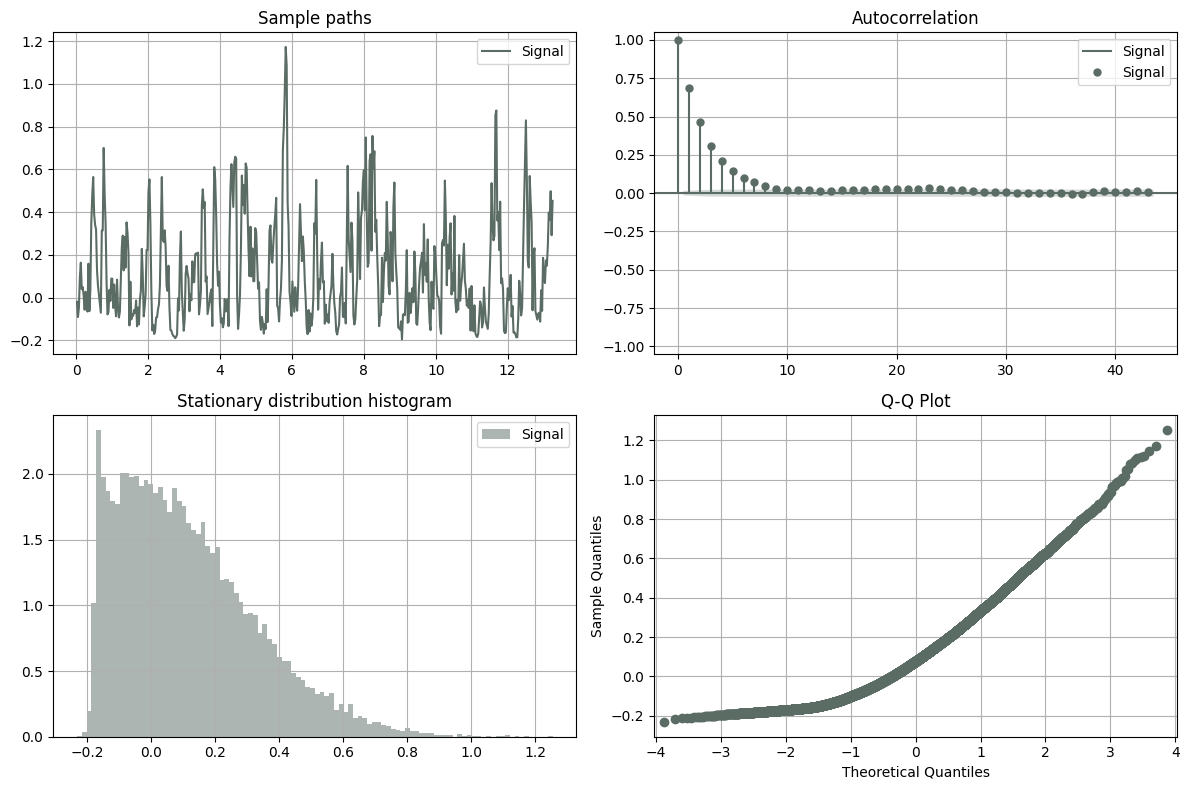

In [9]:
model.analysis(signal_with_model_random_numbers, window_size=500)

In [13]:
def run_calib(weights, optimizer):
    model.loss_weights = weights
    model.optimizer = optimizer
    print(f"Calibrating with weights {model.loss_weights} using the solver {model.optimizer}")
    model.fit(signal)
    print("Calibrated coefficients:")
    print(model.l)
    model.analysis(signal_with_model_random_numbers, window_size=500)

Calibrating with weights (1, 0.0) using the solver BFGS
Esig: 1.2434572593609858, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.67731842  0.04591003  0.74016325 -0.01804991  0.01205768
  0.01377759 -0.10744374], 
 val=1.2434572593609858. 

Esig: 0.8230100488138608, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.62288868  0.04304435  0.79451049 -0.01814076  0.01384609
  0.01474522 -0.1024228 ], 
 val=0.8230100488138608. 

Esig: 0.7385710450478347, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.59395499  0.04585521  0.81180371 -0.01776301  0.01567806
  0.01452076 -0.1718805 ], 
 val=0.7385710450478347. 

Esig: 0.7037177531697635, Stationary moments: 0.0
New iteration: 
 x = [ 0.0030469   0.5586755   0.0541965   0.8144576  -0.01668071  0.02142889
  0.01235852 -0.38381978], 
 val=0.7037177531697635. 

Esig: 0.6424472191142927, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304691  0.50722061  0.06874922  0.80389723 -0.01462834  0.03351394
  0.

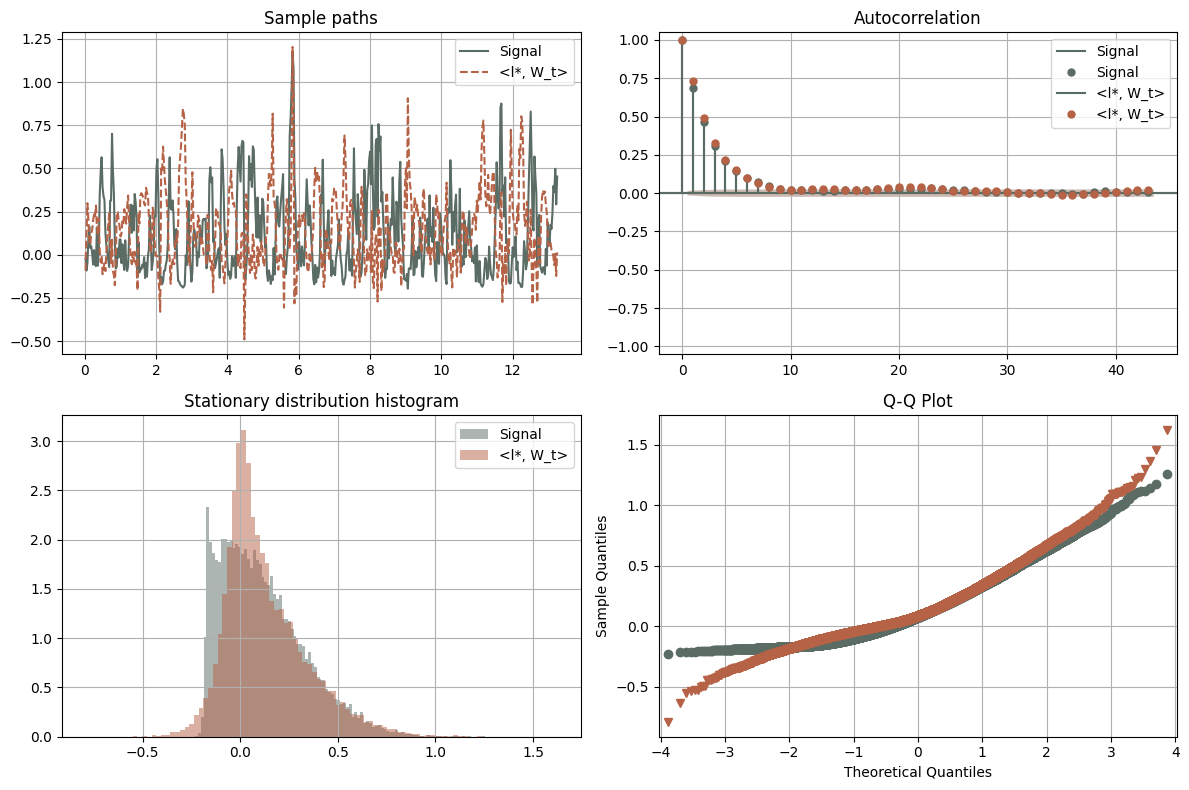

CPU times: total: 30min 34s
Wall time: 32min 15s


In [104]:
%%time
run_calib(weights=(1, 0.0), optimizer="BFGS")

In [12]:
%%time
run_calib(weights=(1, 0.0), optimizer="Powell")

Calibrating with weights (1, 0.0) using the solver Powell
Esig: 0.1868646095767128, Stationary moments: 0.0
New iteration: 
 x = [ 0.04709412 -0.00535917  0.0073747   0.00941743 -0.02886798 -0.01217388
  0.00114416 -0.00260316], 
 val=0.1868646095767128. 

Esig: 0.17870288596214623, Stationary moments: 0.0
New iteration: 
 x = [ 0.19705746 -0.00532848  0.00728305  0.00942771 -0.03713536 -0.01142796
  0.00105296 -0.00211632], 
 val=0.17870288596214623. 

Esig: 0.14571905706409374, Stationary moments: 0.0
New iteration: 
 x = [ 2.51162065e+00 -5.09108826e-03  6.52242308e-03  9.51030063e-03
 -1.03167880e-01 -5.51948994e-03  5.72817184e-04  1.75468029e-03], 
 val=0.14571905706409374. 

Esig: 0.14556951878539467, Stationary moments: 0.0
New iteration: 
 x = [ 2.37714517e+00 -5.09217956e-03  6.47134289e-03  9.51286506e-03
 -1.04897215e-01 -5.41114191e-03  8.04551131e-04  1.74627978e-03], 
 val=0.14556951878539467. 

Esig: 0.13441418132325805, Stationary moments: 0.0
New iteration: 
 x = [-1.

AttributeError: module 'signature.signature.tensor_algebra' has no attribute 'print'

Calibrating with weights (1, 0.0) using the solver Powell
Esig: 0.18686460952392644, Stationary moments: 0.0
New iteration: 
 x = [ 0.00980746 -0.00535917  0.0073747   0.00941743 -0.02886798 -0.01217388
  0.00114416 -0.00260316], 
 val=0.18686460952392644. 

Esig: 0.1787065014397965, Stationary moments: 0.0
New iteration: 
 x = [ 1.04243197 -0.00532848  0.00728305  0.00942771 -0.03713541 -0.01142796
  0.00105117 -0.00211658], 
 val=0.1787065014397965. 

Esig: 0.14572000592250883, Stationary moments: 0.0
New iteration: 
 x = [ 9.08342578e+00 -5.09123400e-03  6.52288281e-03  9.51028310e-03
 -1.03118667e-01 -5.52484276e-03  5.57705093e-04  1.75005452e-03], 
 val=0.14572000592250883. 

Esig: 0.14557092030063545, Stationary moments: 0.0
New iteration: 
 x = [ 9.05954165e+00 -5.09194381e-03  6.47100052e-03  9.51297758e-03
 -1.04955507e-01 -5.40665908e-03  7.87986935e-04  1.74736769e-03], 
 val=0.14557092030063545. 

Esig: 0.13434433164119922, Stationary moments: 0.0
New iteration: 
 x = [ 8.

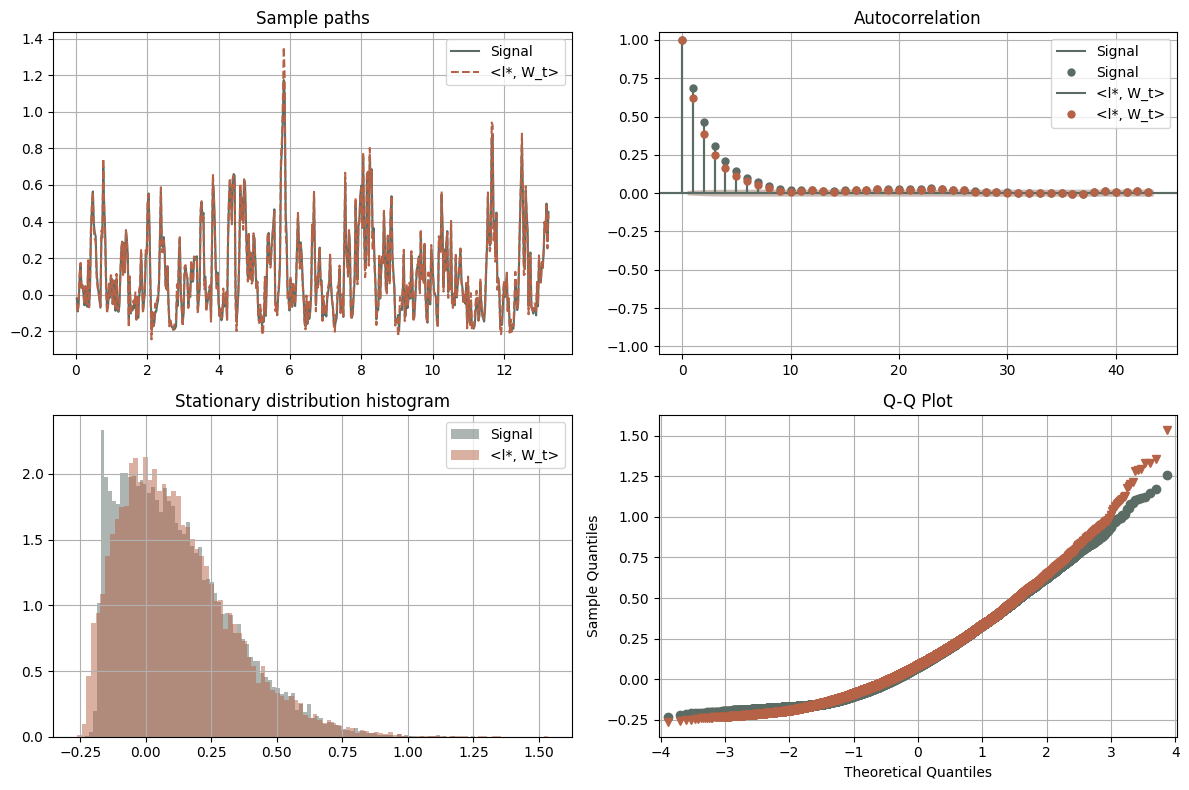

CPU times: total: 16min 11s
Wall time: 17min 7s


In [105]:
%%time
run_calib(weights=(1, 0.0), optimizer="Powell")

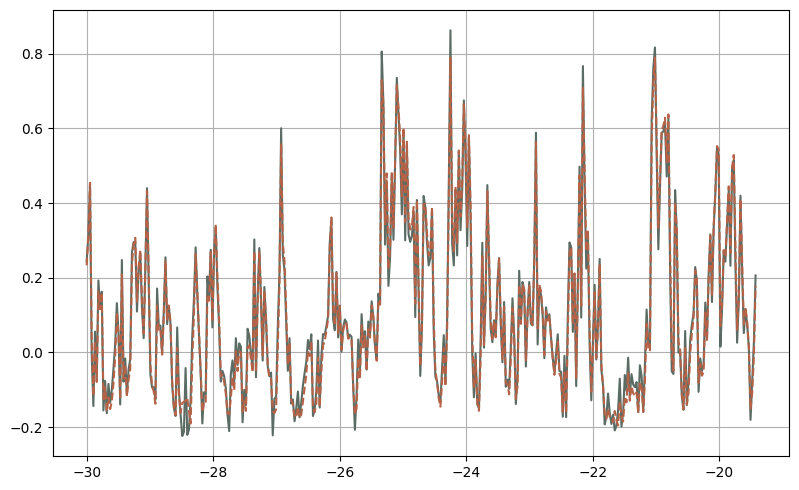

In [109]:
n_show = 400

signal_learnt = (model.l @ SigS).squeeze().real
plt.plot(t_grid[:n_show], signal_learnt[:n_show])
plt.plot(t_grid[:n_show], signal[:n_show], "--")

In [108]:
ta.print(ell)

0.08*∅ + -1.4*2 + 4.0*12 + 2.0*22 + 6.0*112 + 3.0*122 + 10.0*212 + 5.0*222


$0.08279806755071747*∅ + -0.99311116068877*2 + -1.0396880734344074*12 + 1.8785188822194647*22 + -94.9238552617246*112 + 3.8421397610372106*122 + 10.288175070416635*212 + -0.32715551466151443*222$


#### Strip the BM

In [61]:
%%time
W_strip = strip_bm_path(signal=signal, t_grid=t_grid_pos, ts=ell, trunc=2, lam=lam)

100%|█████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 428.52it/s]

CPU times: total: 6.88 s
Wall time: 11.7 s


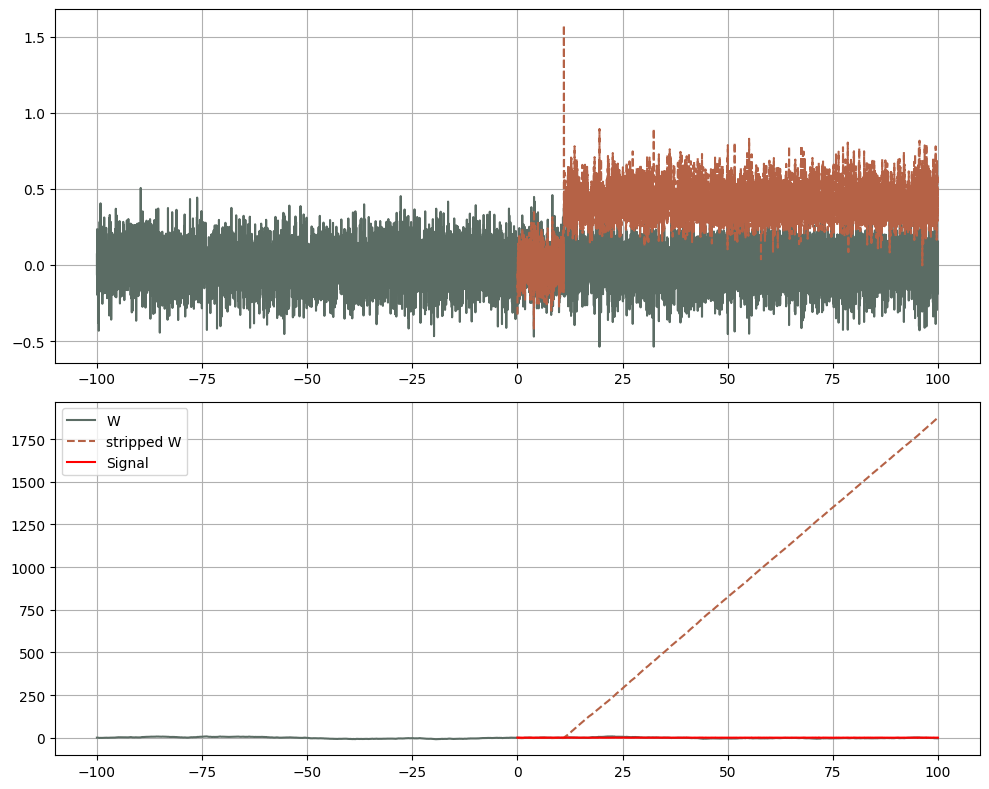

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(t_grid[1:], np.diff(W))
ax[0].plot(t_grid_pos[1:], np.diff(W_strip), "--")

ax[1].plot(t_grid, W, label="W")
ax[1].plot(t_grid_pos, W_strip - W_strip[0] + W[np.where(t_grid >= 0)[0][0]], "--", label="stripped W")

ax[1].plot(t_grid_pos, signal, 'r', label="Signal")

plt.legend()

# Standard Signatures

In [5]:
T = 0.5
t_grid = np.linspace(0, T, 200 + 1)
rng = np.random.default_rng(seed=50)

size = 10

In [6]:
%%time

diffusion = Diffusion(t_grid=t_grid, size=size, rng=rng)

path = np.empty((len(t_grid), 2, size))
path[:, 0, :] = np.tile(t_grid[:, None], size)
path[:, 1, :] = diffusion.brownian_motion()[:, 0, :].T

Sig = ta.path_to_sequence(path=path, trunc=N)

CPU times: total: 93.8 ms
Wall time: 267 ms


In [54]:
#ell = e1 * (1) + e2 * (-1) + e11 * 6 + e12 * (-2) + e21 * (-6) + e22 * 2
ell = e22 + e21 * (-1) + e12 * (-1)
ell_Sig = (ell @ Sig)

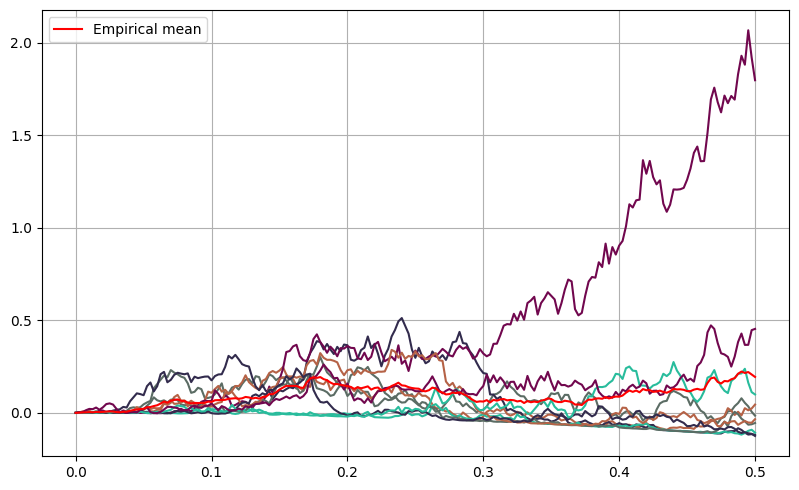

In [55]:
for i in range(10):
    plt.plot(t_grid, ell_Sig[:, i])

plt.plot(t_grid, ell_Sig.mean(axis=1), "r", label="Empirical mean")
plt.legend()

In [76]:
from jax import random

In [69]:
trunc_moments = 4
trunc_ell = 2

signature_of_signal = get_signature_of_linear_form(ts=ell, trunc_moments=trunc_moments, ta=ta)
eSig = expected_signature(t=T, trunc=trunc_moments * trunc_ell)
expected_signal_signature_arr = np.zeros(ta.alphabet.number_of_elements(trunc_moments))
for i, (word, coef) in enumerate(signature_of_signal.items()):
    expected_signal_signature_arr[i] = (signature_of_signal[word] @ eSig).real.squeeze()
expected_signal_signature = ta.from_array(trunc=trunc_moments, array=expected_signal_signature_arr)

In [70]:
model = SigSignal(trunc=trunc_ell, T=T, trunc_signature_moments=trunc_moments)

Compiling...
Compilation finished.


In [71]:
model.fit(expected_signal_signature)

New iteration: 
 x = [ 1.11819379 -0.63519517 -1.54618185 -0.92721617  0.00725711  0.04768261], 
 val=1.9199655509831346. 

New iteration: 
 x = [ 1.03668678 -0.63518882 -1.50746437 -0.91505587 -0.08098301  0.08711244], 
 val=1.78527516871292. 

New iteration: 
 x = [ 0.55543013 -0.58875169 -1.07817207 -0.78058403 -0.60249921  0.32032802], 
 val=1.2456065124839943. 

New iteration: 
 x = [ 0.43608981 -0.47904599 -0.72400493 -0.82950631 -0.73190835  0.41596669], 
 val=1.0124106399747226. 

New iteration: 
 x = [-0.06430795 -0.02692789  0.51306171 -1.02916544 -1.27450565  0.84355385], 
 val=0.24122271221478842. 

New iteration: 
 x = [-0.0616144  -0.02404211  0.3919031  -1.02665054 -1.27155861  0.86427008], 
 val=0.2108312023543961. 

New iteration: 
 x = [-0.04453728 -0.01422878  0.04359209 -1.0077204  -1.24713517  0.92716016], 
 val=0.17736491374263436. 

New iteration: 
 x = [-0.04111927 -0.01298457  0.02317631 -1.00762376 -1.23659507  0.93211611], 
 val=0.1699616929213772. 

New iter

In [72]:
ta.print(ell)

-1.0*12 + -1.0*21 + 1.0*22


In [73]:
ta.print(model.l)

0.02483441951071546*1 + 0.01748553690931524*2 + -0.07822134326657149*11 + -1.0841629333729887*12 + -1.0190476509909723*21 + 0.989441832320585*22


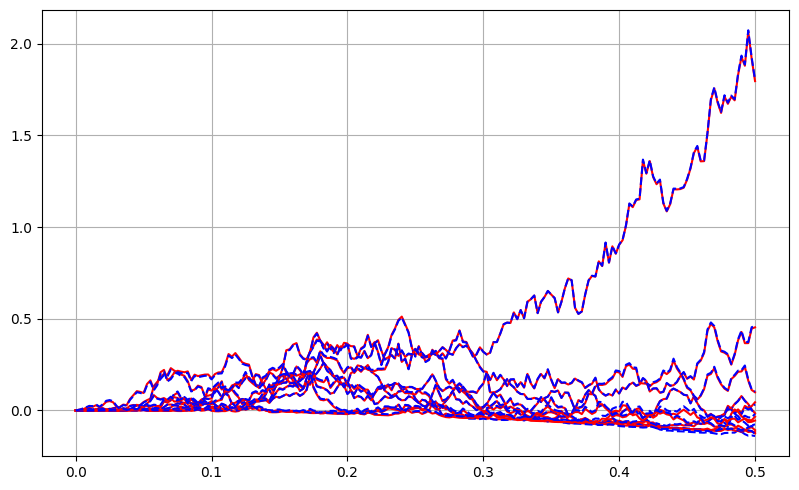

In [74]:
l_Sig = model.l @ Sig

for i in range(10):
    plt.plot(t_grid, ell_Sig[:, i], "r")
    plt.plot(t_grid, l_Sig[:, i], "b--")

#### Calculating the signature of signal

In [ ]:
%%time
signal = ell_Sig.real

path_signal = np.empty((len(t_grid), 2, size))
path_signal[:, 0, :] = np.tile(t_grid[:, None], size)
path_signal[:, 1, :] = signal

SignalSig = ta.path_to_sequence(path=path_signal, trunc=N)

In [152]:
trunc_moments = 4
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

np.array(words)

array(['∅', '1', '2', '11', '12', '21', '22', '111', '112', '121', '122',
       '211', '212', '221', '222', '1111', '1112', '1121', '1122', '1211',
       '1212', '1221', '1222', '2111', '2112', '2121', '2122', '2211',
       '2212', '2221', '2222'], dtype='<U4')

In [153]:
def signal_signature_coefs_as_bm_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1")
            elif word.endswith("2"):
                signal_sig_coefs_exact[word] = ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("1")).tensor_prod_word("1") + \
                                               ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("2")).tensor_prod_word("2")
    return signal_sig_coefs_exact

In [154]:
%%time
signal_sig_coefs_exact = signal_signature_coefs_as_bm_signature_coefs(ell, trunc_moments)

CPU times: total: 0 ns
Wall time: 7.12 ms


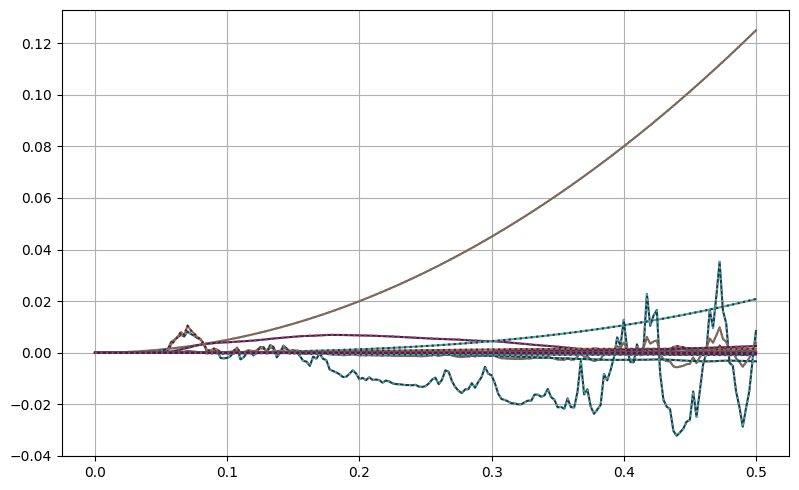

In [155]:
for word in words:
    if len(word) < 2:
        continue
    plt.plot(t_grid, (signal_sig_coefs_exact[word] @ Sig)[:, 0])
    plt.plot(t_grid, (ta.from_dict({word: 1}, trunc=8) @ SignalSig)[:, 0], ":")

In [156]:
%%time
eSig = expected_signature(t=t_grid, trunc=N)

CPU times: total: 125 ms
Wall time: 315 ms


In [157]:
%%time

expected_signal_sig_estimator = dict()
expected_signal_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_sig_estimator[word] = SignalSig.array[idx].mean(axis=1)
    expected_signal_sig_exact[word] = (signal_sig_coefs_exact[word] @ eSig).squeeze()

CPU times: total: 31.2 ms
Wall time: 53.6 ms


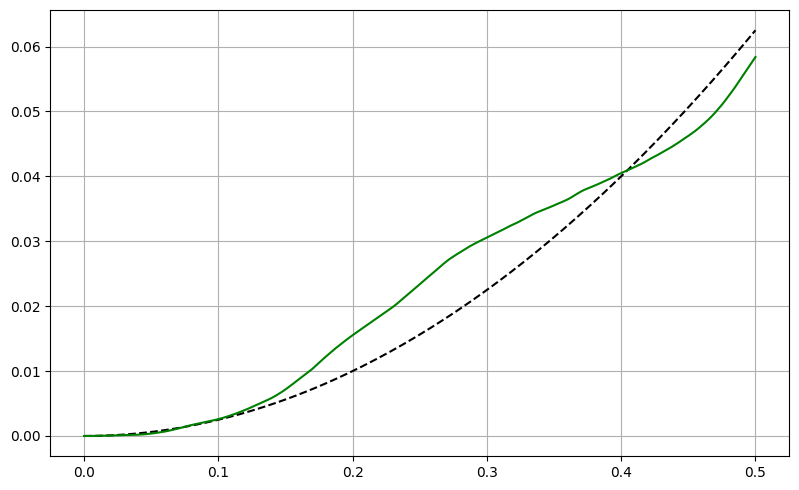

In [158]:
w = "21"
plt.plot(t_grid, expected_signal_sig_exact[w], "k--")
plt.plot(t_grid, expected_signal_sig_estimator[w], "g")

##### Loss functional for a given $l$

In [159]:
from math import factorial

In [172]:
expected_signal_sig_exact[word][-1]

(0.04833984375+0j)

In [173]:
ell_trunc = 2

def loss(x):    
    l = ta.from_array(N, x)
    signal_sig_coefs = signal_signature_coefs_as_bm_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_sig_coefs[word] @ eSig)[-1].squeeze() - expected_signal_sig_exact[word][-1])**2))
            loss += loss_word * factorial(len(word))
    return loss

In [174]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [175]:
%%time
loss(x0)

CPU times: total: 15.6 ms
Wall time: 57.4 ms


4.76953125

In [177]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss, x0, callback=callback, method="Powell")
print(res)

New iteration: 
 x = [ 2.58792896  1.11819379 -0.63519517 -1.54618185 -0.92721617  0.00725711
  0.04768261], 
 val=1.9199655509831346. 

New iteration: 
 x = [ 5.17585792  1.03668678 -0.63518882 -1.50746437 -0.91505587 -0.08098301
  0.08711244], 
 val=1.78527516871292. 

New iteration: 
 x = [23.04416487  0.55543013 -0.58875169 -1.07817207 -0.78058403 -0.60249921
  0.32032802], 
 val=1.2456065124839943. 

New iteration: 
 x = [29.42126811  0.43608981 -0.47904599 -0.72400493 -0.82950631 -0.73190835
  0.41596669], 
 val=1.0124106399747226. 

New iteration: 
 x = [ 5.85626576e+01 -6.43079526e-02 -2.69278871e-02  5.13061711e-01
 -1.02916544e+00 -1.27450565e+00  8.43553850e-01], 
 val=0.24122271221478842. 

New iteration: 
 x = [ 6.11331491e+01 -6.16144041e-02 -2.40421147e-02  3.91903097e-01
 -1.02665054e+00 -1.27155861e+00  8.64270078e-01], 
 val=0.2108312023543961. 

New iteration: 
 x = [ 7.17520311e+01 -4.45372812e-02 -1.42287776e-02  4.35920917e-02
 -1.00772040e+00 -1.24713517e+00  9.2

In [178]:
loss(ell.array.squeeze().real[:7])

0.0

In [183]:
x_opt = res.x
x_opt[0] = ell[""][0, 0].real
x_opt[[2, 4, 5]] *= -1
l_opt = ta.from_array(trunc_moments, x_opt)
ta.print(l_opt)

0.02483441951071546*1 + -0.01748553690931524*2 + -0.07822134326657149*11 + 1.0841629333729887*12 + 1.0190476509909723*21 + 0.989441832320585*22


In [184]:
ta.print(ell)

1.0*12 + 1.0*21 + 1.0*22


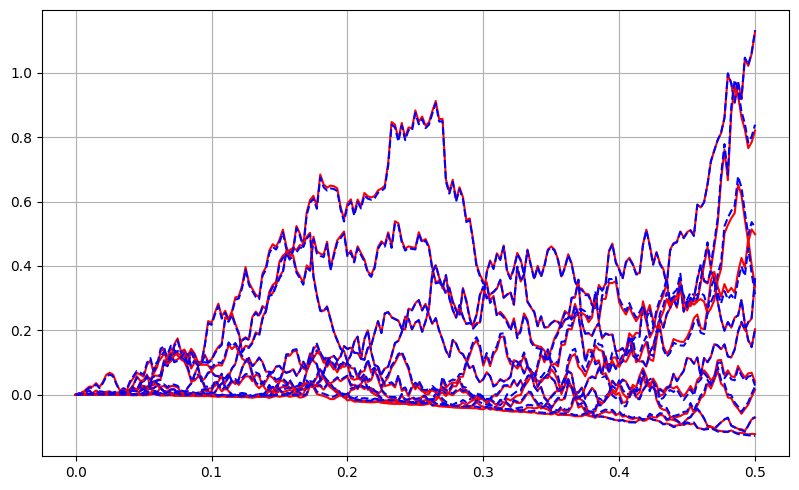

In [186]:
l_Sig = l_opt @ Sig

for i in range(10):
    plt.plot(t_grid, ell_Sig[:, i], "r")
    plt.plot(t_grid, l_Sig[:, i], "b--")

## Stationary Signature of signal (does not work properly)

In [150]:
T = 50
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 3
size = 2

In [151]:
%%time
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_grid, lam=lam)

W2 = diffusion.brownian_motion()[1, 0, :]
path2 = np.vstack([t_grid, W2]).T
SigS_test = stationary_signature_from_path(path=path2, trunc=trunc_moments, t_grid=t_grid, lam=lam)

CPU times: total: 29 s
Wall time: 31.2 s


In [298]:
ell = e2 + e22 * 2
ell_SigS = (ell @ SigS).squeeze().real
ell_SigS_test = (ell @ SigS_test).squeeze().real

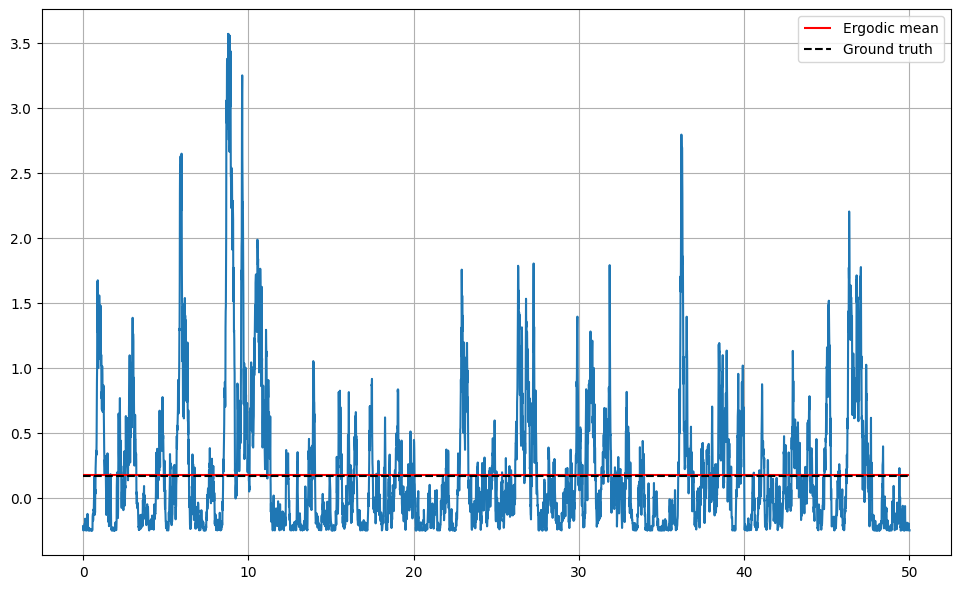

In [301]:
plt.plot(t_grid_pos, ell_SigS)

plt.hlines(ell_SigS.mean(), t_grid_pos[0], t_grid_pos[-1], "r", label="Ergodic mean")
plt.hlines(1 / 2 / lam, t_grid_pos[0], t_grid_pos[-1], "k", linestyles="--", label="Ground truth")

plt.legend()

#### Calculating the signature of signal

In [14]:
%%time
signal = ell_SigS.real

path_signal = np.empty((len(t_grid_pos), 2))
path_signal[:, 0] = t_grid_pos
path_signal[:, 1] = signal

SignalSigS = stationary_signature_from_path(path=path_signal, trunc=N, t_grid=t_grid_pos - 15, lam=lam)

t_grid_s = t_grid_pos[t_grid_pos >= 15]

CPU times: total: 11.4 s
Wall time: 12 s


In [91]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments

15

In [21]:
def resolvent(mu, lam, ts):
    tmp = ts * 1
    res = ts * 1
    for i in range(N):
        tmp.update(G(tmp) * lam - tmp * mu)
        tmp.update(tmp.tensor_prod_word("1"))
        res.update(res + tmp)

    return res

In [22]:
def signal_stat_signature_coefs_as_bm_stat_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1"))
            elif word.endswith("2"):
                coef_prev = signal_sig_coefs_exact[word[:-1]]
                c = (ta.shuop.shuffle_prod(coef_prev, ts.proj("1") - G(ts) * lam) - ta.shuop.shuffle_prod(coef_prev.proj("2") / 2, ts.proj("2"))).tensor_prod_word("1") + \
                    ta.shuop.shuffle_prod(coef_prev, ts.proj("2")).tensor_prod_word("2")
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=c)
    return signal_sig_coefs_exact

In [23]:
%%time
signal_stat_sig_coefs_exact = signal_stat_signature_coefs_as_bm_stat_signature_coefs(ell, trunc_moments)

CPU times: total: 5.41 s
Wall time: 6.2 s


In [24]:
ta.print(signal_stat_sig_coefs_exact["222"])

-1.0*22122 + -3.0*22212 + -6.0*22221 + -3.0*221122 + -3.0*221212 + 3.0*221221 + -9.0*222112 + 9.0*222121 + 18.0*222211 + 15.0*222222 + -18.0*2211122 + -18.0*2211212 + 9.0*2211221 + -18.0*2212112 + 9.0*2212121 + 63.0*2212211 + -9.0*2212222 + -54.0*2221112 + 27.0*2221121 + 189.0*2221211 + -27.0*2221222 + 378.0*2222111 + -54.0*2222122 + -90.0*2222212 + -135.0*2222221 + -162.0*22111122 + -162.0*22111212 + 54.0*22111221 + -162.0*22112112 + 54.0*22112121 + 378.0*22112211 + -54.0*22112222 + -162.0*22121112 + 54.0*22121121 + 378.0*22121211 + -54.0*22121222 + 1026.0*22122111 + -45.0*22122122 + -27.0*22122212 + -486.0*22211112 + 162.0*22211121 + 1134.0*22211211 + -162.0*22211222 + 3078.0*22212111 + -135.0*22212122 + -81.0*22212212 + 6156.0*22221111 + -270.0*22221122 + -162.0*22221212 + -270.0*22222112 + -1944.0*221111122 + -1944.0*221111212 + 486.0*221111221 + -1944.0*221112112 + 486.0*221112121 + 3726.0*221112211 + -486.0*221112222 + -1944.0*221121112 + 486.0*221121121 + 3726.0*221121211 + -486

In [25]:
SigS.array.shape

(1023, 5001, 1)

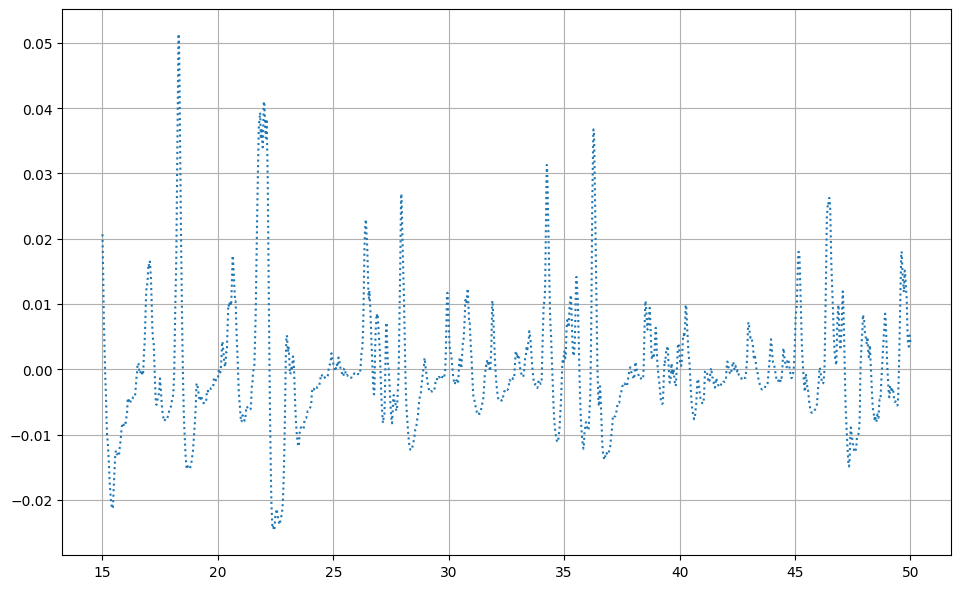

In [30]:
# plt.plot(t_grid_s, (signal_stat_sig_coefs_exact["222"] @ SigS).squeeze()[t_grid_pos >= 15])
plt.plot(t_grid_s, (e21 @ SignalSigS), ":")

In [31]:
%%time
eSigS = expected_stationary_signature(lam=lam, trunc=N)

CPU times: total: 5.41 s
Wall time: 8.23 s


In [281]:
%%time

expected_signal_stat_sig_estimator = dict()
expected_signal_stat_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_stat_sig_estimator[word] = SignalSigS.array[idx].mean()
    expected_signal_stat_sig_exact[word] = (signal_stat_sig_coefs_exact[word] @ eSigS).squeeze()

CPU times: total: 0 ns
Wall time: 0 ns


In [283]:
w = "2"
expected_signal_stat_sig_estimator[w], expected_signal_stat_sig_exact[w]

((1.4819416621710028e-05+0j), array(0.00833333+0.j))

##### Loss functional for a given $l$

In [289]:
ell_trunc = 3

def loss_stat(x):    
    l = ta.from_array(N, x)
    signal_stat_sig_coefs = signal_stat_signature_coefs_as_bm_stat_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_stat_sig_coefs[word] @ eSigS).squeeze() - expected_signal_stat_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [290]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [291]:
%%time
loss_stat(x0)

CPU times: total: 46.9 ms
Wall time: 94.2 ms


0.010321093750000001

In [293]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss_stat(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss_stat, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [ 0.00000000e+00  3.02261860e-01 -3.10481573e-09  3.02261868e-02
  0.00000000e+00  0.00000000e+00  1.25294210e-01  1.51130787e-03
  0.00000000e+00  0.00000000e+00  1.25294218e-02  0.00000000e+00
  0.00000000e+00  6.26471089e-03  0.00000000e+00], 
 val=0.0022176860482609755. 

New iteration: 
 x = [ 0.00000000e+00  3.51610595e-01 -3.54563448e-09  3.51757401e-02
  0.00000000e+00  0.00000000e+00  1.45847824e-01  1.75944838e-03
  0.00000000e+00  0.00000000e+00  1.45880485e-02  0.00000000e+00
  1.26712280e-06  7.29250426e-03  0.00000000e+00], 
 val=0.0011075077325957319. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563451e-09  3.51757406e-02
 -5.11220152e-18  0.00000000e+00  1.45847825e-01  1.75944840e-03
  0.00000000e+00  0.00000000e+00  1.45880487e-02  0.00000000e+00
  1.26712333e-06  7.29250436e-03 -1.70406717e-18], 
 val=0.0011075076513443784. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563442e-09  3.51757427e-02
 -1.42969984e-17  0.

In [295]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

0.3516105983634915*1 + 0.03517576155534584*11 + 0.14584783466533074*22 + 0.0017595189129007553*111 + 0.014588074290246009*122 + 1.28419076285507e-06*212 + 0.007292498171109511*221


In [298]:
l_SigS = l_opt @ SigS

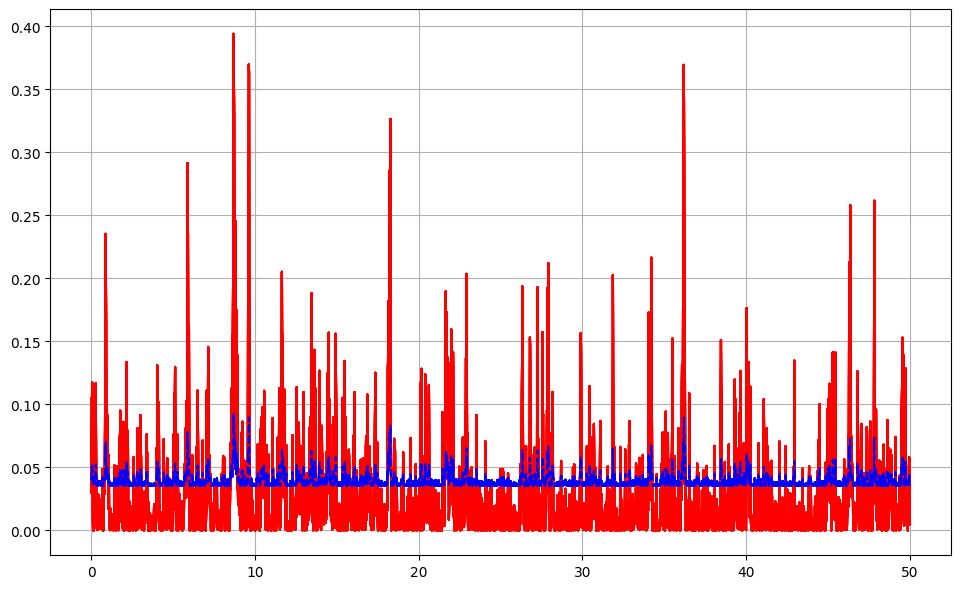

In [299]:
for i in range(10):
    plt.plot(t_grid_pos, ell_SigS, "r")
    plt.plot(t_grid_pos, l_SigS, "b--")